In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import data_visualization as dv
wheel = dv.ColorWheel()

In [1]:
def find_optimal_decision_time_v2(agent_mean, agent_std, reaction_time,movement_time, reaction_uncertainty, movement_uncertainty,timing_uncertainty,plot=False):
    timesteps = np.arange(0,2000,1)
    prob_agent_go = np.zeros(len(timesteps))
    prob_agent_no_go = np.zeros(len(timesteps))
    prob_making_react = np.zeros(len(timesteps))
    prob_making_gamble = np.zeros(len(timesteps))
    prob_agent_making = np.zeros(len(timesteps))

    expected_reward = np.zeros(len(timesteps))
    expected_reward_gamble = np.zeros(len(timesteps))
    expected_reward_react = np.zeros(len(timesteps))
    prob_reward_gamble = np.zeros(len(timesteps))
    prob_reward_react = np.zeros(len(timesteps))
    prob_reward = np.zeros(len(timesteps))
    reaction_movement_time = reaction_time + movement_time


    prob_success_gamble = 0.5 # IT'S NOT ABOUT THE PROBABILITY THAT I WILL SUCCEED WITH EACH ACTION... IT'S ABOUT THE PROBABILITY THAT I WILL BE ABLE TO SELECT THE OPTIMAL ACTION
    prob_success_react = 1.0
    win_reward = 1.0
    loss_cost = 0
    indecision_cost = 0
    
    prob_agent_go = stats.norm.cdf(timesteps,agent_mean,agent_std)
    prob_agent_no_go = 1 - prob_agent_go
    prob_agent_making = stats.norm.cdf(1500-timesteps,agent_mean,agent_std)
    
    
    # Calculate reaction movement uncertainty basedon prob_agent_go
    reaction_movement_uncertainty = np.sqrt((movement_uncertainty)**2 + prob_agent_go*(reaction_uncertainty**2)) # We have some uncertainty about making it  
    total_uncertainty_reaction = np.sqrt(reaction_movement_uncertainty**2) #+ timing_uncertainty**2)
    total_uncertainty_gamble = np.sqrt(movement_uncertainty**2 + timing_uncertainty**2)  
    
    prob_making_react = stats.norm.cdf(1500-timesteps,reaction_movement_time,total_uncertainty_reaction)
    prob_making_gamble = stats.norm.cdf(1500-timesteps,movement_time,total_uncertainty_gamble)

    # THESE AREN'T Multiplied by Agent Probability     
    prob_reward_gamble = (prob_success_gamble)*prob_making_gamble 
    prob_cost_gamble = (1-prob_success_gamble)*prob_making_gamble # Probability of receiving the Cost for being incorrect
    
    prob_reward_react = (prob_success_react)*prob_making_react 
    prob_cost_react = ((1-prob_success_react))*prob_making_react # Probability of receiving the Cost for being incorrect
    
    prob_indecision_gamble = (1 - prob_making_gamble)
    prob_indecision_react = (1 - prob_making_react)    
    
    # Don't need AND subtraction because the prob_agent_go and prob_agent_no_go takes care of it
    # These are multiplied by agent probability, because that's the probability that I SELECT GAMBLE and SELECT REACTION
    prob_reward = prob_reward_gamble*prob_agent_no_go + prob_reward_react*prob_agent_go #- (prob_reward_gamble*prob_reward_react) # NEED TO SUBTRACT THE AND PROBABILITY?... this makes sense... If I go at that time, I at least have 0.5 PLUS the probability that the agent has gone will boost it up
    prob_cost = prob_cost_gamble*prob_agent_no_go + prob_cost_react*prob_agent_go # - (prob_cost_react*prob_cost_gamble)
    prob_indecision = prob_indecision_gamble*prob_agent_no_go + prob_indecision_react*prob_agent_go #- (prob_indecision_gamble*prob_indecision_react) # Probability of indecision depends on if someone gambles
    
    #prob_indecision = prob_indecision_gamble*(1-B) + prob_indecision_react*B - prob_indecision_gamble*(1-B)*B*prob_indecision_react # Probability of indecision depends on if someone gambles 
    
    exp_reward_gamble = prob_reward_gamble*win_reward + prob_cost_gamble*loss_cost + prob_indecision_gamble*indecision_cost
    exp_reward_react = prob_reward_react*win_reward + prob_cost_react*loss_cost + prob_indecision_gamble*indecision_cost
    exp_reward = prob_reward*win_reward + prob_cost*loss_cost + (prob_indecision)*indecision_cost
    
    return np.argmax(exp_reward),np.max(exp_reward),total_uncertainty_reaction,total_uncertainty_gamble

In [12]:
# def plot_optimals(timesteps,exp_reward,exp_reward_gamble,exp_reward_react,prob_reward_gamble,prob_reward_react,
#                   prob_agent_go,prob_agent_no_go,
#                   prob_reward, movement_time,reaction_movement_time):
#     fig,ax = plt.subplots(dpi = 125)
#     ax.plot(timesteps, exp_reward, label = 'Exp Reward', c = wheel.green, ls = '--')
#     ax.plot(timesteps, exp_reward_gamble, label = 'Exp Reward Gamble')
#     ax.plot(timesteps, exp_reward_react, label = 'Exp Reward React')
#     ax.plot(timesteps,prob_reward_gamble*prob_agent_no_go,label='Gamble Reward*ProbAgentNoGo')
#     ax.plot(timesteps,prob_reward_react*prob_agent_go,label = 'React Reward*ProbAgentGo')
#     # ax.plot(timesteps, prob_indecision_gamble)
#     ax.set_ylim(-1,1.1)
#     ax.set_xlim(0,1500)
#     ax.set_xticks(np.arange(0,2000,300))
#     ax.set_xlabel('Time (ms)')
#     ax.set_ylabel('Expected Reward')
#     ax.legend(fontsize = 8,loc = (0.01,0.1))
#     ax.set_title(f'Gain Function for Decision Time')#\n B = {B}')
#     plt.show()
#     optimal_decision_time  = np.argmax(prob_reward) 
#     target_reach_time_on_gambles = optimal_decision_time + movement_time 
#     target_reach_time_on_reactions = optimal_decision_time + reaction_movement_time
#     print(f'Optimal Decision Time: {optimal_decision_time}') # Remember the task decision time is this 
#     print(f'Maximum Expected Reward: {np.max(prob_reward)}')
#     print(f'Gamble Target Reach Time: {target_reach_time_on_gambles}')
#     print(f'Reaction Target Reach Time: {target_reach_time_on_reactions}')

(0.0, 0.1)

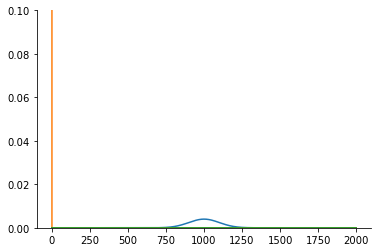

In [37]:
mu = 1000
std = 100
clip_a,clib_b = 1000,1033
a,b = (clip_a - mu)/std, (clib_b - mu)/std
x = np.arange(0,2000,1)
trunc_pdf = stats.truncnorm.pdf(x,a,b)
pdf = stats.norm.pdf(x,mu,std)
fig, ax = plt.subplots()

ax.plot(x,pdf)
ax.plot(x,trunc_pdf)
rv = stats.truncnorm.pdf(x,10,20,loc=mu,scale=std)
ax.plot(x,rv)
ax.set_ylim(0,0.1)

0.0